In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\

In [2]:
train_df_ = pd.read_csv('bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('bengaliai-cv19/sample_submission.csv')

In [3]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [5]:
print(class_map_df.head())
class_map_df['component_type'].value_counts()

  component_type  label component
0  grapheme_root      0         ং
1  grapheme_root      1         ঃ
2  grapheme_root      2         অ
3  grapheme_root      3         আ
4  grapheme_root      4         ই


grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64

In [6]:
class_map_df[class_map_df['label']==9]

,component_type,label,component
9,grapheme_root,9,এ
177,vowel_diacritic,9,ো


In [7]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


## EDA

In [8]:
HEIGHT = 236
WIDTH = 236

# def get_n(df, field, n, top = True):
    

In [9]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('bengaliai-cv19/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

     index component  count
72      72         দ   5736
64      64         ত   5596
13      13         ক   5420
107    107         ব   5321
23      23         গ   5149
96      96         প   4926
113    113         ভ   4395
147    147         স   4392
133    133         শ   4374
115    115         ম   4015


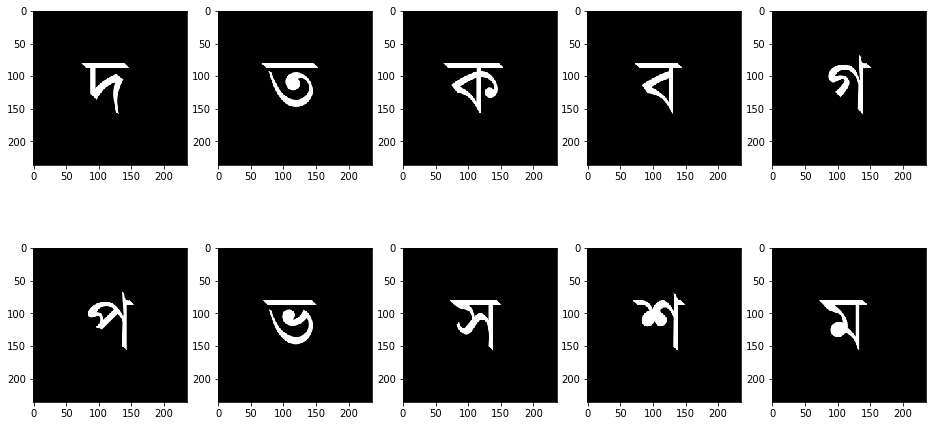

In [10]:
# Grapheme_root
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
print(top_10_roots)

f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

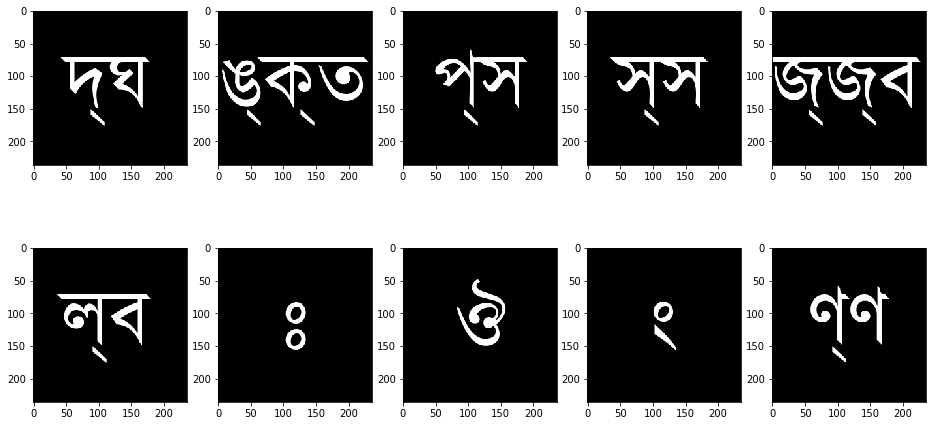

In [11]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

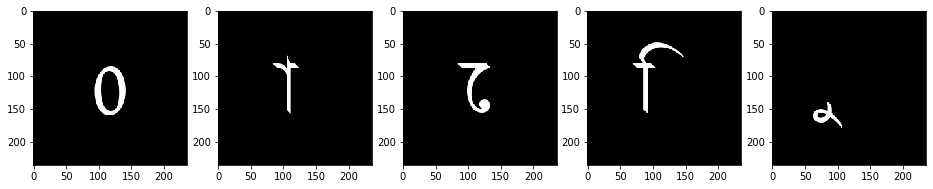

In [12]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

In [13]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [14]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [15]:
IMG_SIZE=64
N_CHANNELS = 1

In [16]:
# # Clip horizontally
# def clip(img):
#     cols = np.any(img < 200, axis=0)
#     xleft, xright = np.where(cols)[0][[0, -1]]
#     width = xright - xleft
#     center = int((xleft + xright) / 2)
    
#     if width < 137:
#         img = img[:, max(0, center - 70):min(center + 70, 236)]
#     else:
#         img = img[:, max(0, xleft - 2):min(xright + 2, 236)]
        
#     return img
# def resize(df, size=128):
#     resized = {}
#     for i in range(df.shape[0]):
#         img = clip(df.loc[df.index[i]].values.reshape(137,236))
#         image = cv2.resize(img,(size,size))
#         resized[df.index[i]] = image.reshape(-1)
#     resized_df = pd.DataFrame(resized).T
#     return resized_df

In [17]:
# Image Processing while resizing the images, 
# center crop
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [18]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

# Basic Model

In [19]:
# inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = Dropout(rate=0.3)(model)

# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

# model = Flatten()(model)
# model = Dense(1024, activation = "relu")(model)
# model = Dropout(rate=0.3)(model)
# dense = Dense(512, activation = "relu")(model)

# head_root = Dense(168, activation = 'softmax')(dense)
# head_vowel = Dense(11, activation = 'softmax')(dense)
# head_consonant = Dense(7, activation = 'softmax')(dense)

# model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [29]:
from keras_applications.resnext import ResNeXt101
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras_efficientnets import EfficientNetB3
from keras import backend as K
from keras import layers, models, optimizers, utils, backend,regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras import layers, models, optimizers, utils, backend,regularizers
from keras.layers import LeakyReLU
def get_model(model_name='EfficientNetB3'):
#     inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
    resNet_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(64,64,3))
#     resNet_model = DenseNet121(include_top= False, input_shape = (128,128,3)
#                             , backend =backend, layers=layers, models = models,
#                              utils = utils
#                             )
    
#     densenet = DenseNet121(weights='imagenet', include_top=False)

#     input = Input(shape=(SIZE, SIZE, N_ch))
#     x = Conv2D(3, (3, 3), padding='same')(input)
    
    inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
    model = Conv2D(3, (3, 3), padding='same')(inputs)
    model = resNet_model(model)
    # resNet_model.summary()
    
#     model = Sequential()
#     model.add(resNet_model)
#     model.add(GlobalAveragePooling2D())
#     model.add(layers.Dropout(0.25))  # 과적합 줄여보기
#     model.add(Dense(196, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l=0.01)))
#     #model.add(Dense(196, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l=0.01)))
#    # model.add(LeakyReLU(alpha=0.01))
    
#     model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

#     model = resNet_model.layers[-1].output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(rate=0.3)(model)
    
#     model = Flatten()(model)
    model = Dense(1024, activation = "relu")(model)
    model = Dropout(rate=0.3)(model)
    dense = Dense(512, activation = "relu")(model)
    
    head_root = Dense(168, activation = 'softmax')(model)
    head_vowel = Dense(11, activation = 'softmax')(model)
    head_consonant = Dense(7, activation = 'softmax')(model)

    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
    
    model.summary()
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer = adam,loss = 'categorical_crossentropy', metrics=['accuracy'])
    # compile 할때 넣어줘야지 아래에서 early stopping 할때 사용 가능하다
    return model

In [30]:
model = get_model()

43974656/43966704 [==============================] - 591s 13us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 64, 64, 3)    30          input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2, 2, 1536)   10783528    conv2d_105[0][0]                 
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1536)         0           model_1[1][0]                    
________________________

In [31]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [32]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
from keras.callbacks import  EarlyStopping
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
# Callback : Early Stop
earlyStop = EarlyStopping(monitor='val_root_accuracy',
                          mode = 'auto',
                          patience = 4,
                          min_delta = 0,
                          verbose = 1)

In [34]:
batch_size = 100
epochs = 100

In [35]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=200,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [36]:
HEIGHT = 137
WIDTH = 236

In [37]:
# # from tensorflow.python.client import device_lib

# # print(device_lib.list_local_devices())

# from keras import backend as K

# K.tensorflow_backend._get_available_gpus()



In [38]:
# from keras.backend.tensorflow_backend import set_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import get_session
# import tensorflow

# # Reset Keras Session
# def reset_keras():
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     try:
#         del classifier # this is from global space - change this as you need
#     except:
#         pass

#     print(gc.collect()) # if it's done something you should see a number being outputted

#     # use the same config as you used to create the session
#     config = tensorflow.ConfigProto()
#     config.gpu_options.per_process_gpu_memory_fraction = 1
#     config.gpu_options.visible_device_list = "0"
#     set_session(tensorflow.Session(config=config))
# reset_keras()

In [39]:
# ## LIMIT GPU USAGE
# import tensorflow as tf
# from keras import backend as K
# config = tf.ConfigProto()  
# config.gpu_options.allow_growth = True  # don't pre-allocate memory; allocate as-needed
# config.gpu_options.per_process_gpu_memory_fraction = 0.95  # limit memory to be allocated
# K.tensorflow_backend.set_session(tf.Session(config=config)) # create sess w/ above settings

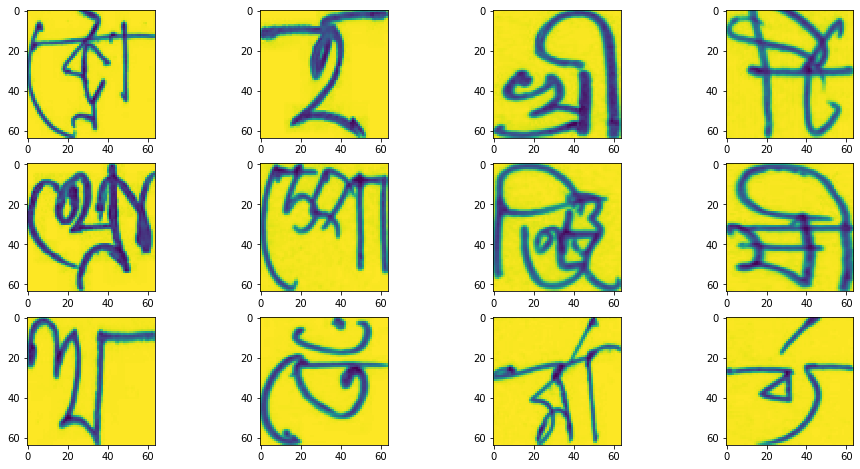


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)

Epoch 1/100
461/461 [==============================] - 73s 159ms/step - loss: 7.5452 - dense_3_loss: 4.7425 - dense_4_loss: 1.6954 - dense_5_loss: 1.1073 - dense_3_accuracy: 0.0362 - dense_4_accuracy: 0.4196 - dense_5_accuracy: 0.6391 - val_loss: 6.2203 - val_dense_3_loss: 4.4760 - val_dense_4_loss: 0.9731 - val_dense_5_loss: 0.7764 - val_dense_3_accuracy: 0.0588 - val_dense_4_accuracy: 0.6774 - val_dense_5_accuracy: 0.7354


C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_root_accuracy` which is not available. Available metrics are: val_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_3_accuracy,val_dense_4_accuracy,val_dense_5_accuracy,loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_3_accuracy,dense_4_accuracy,dense_5_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100
461/461 [==============================] - 60s 130ms/step - loss: 5.9392 - dense_3_loss: 4.2249 - dense_4_loss: 0.9694 - dense_5_loss: 0.7450 - dense_3_accuracy: 0.0804 - dense_4_accuracy: 0.6704 - dense_5_accuracy: 0.7481 - val_loss: 4.8136 - val_dense_3_loss: 3.7405 - val_dense_4_loss: 0.5590 - val_dense_5_loss: 0.5102 - val_dense_3_accuracy: 0.1474 - val_dense_4_accuracy: 0.8208 - val_dense_5_accuracy: 0.8218
Epoch 3/100
461/461 [==============================] - 59s 129ms/step - loss: 4.7321 - dense_3_loss: 3.4587 - dense_4_loss: 0.7319 - dense_5_loss: 0.5416 - dense_3_accuracy: 0.1791 - dense_4_accuracy: 0.7535 - dense_5_accuracy: 0.8158 - val_loss: 3.4416 - val_dense_3_loss: 2.6706 - val_dense_4_loss: 0.4173 - val_dense_5_loss: 0.3464 - val_dense_3_accuracy: 0.3186 - val_dense_4_accuracy: 0.8623 - val_dense_5_accuracy: 0.8778
Epoch 4/100
461/461 [==============================] - 59s 128ms/step - loss: 3.5925 - dense_3_loss: 2.5533 - dense_4_loss: 0.6034 - dense_5_los

461/461 [==============================] - 58s 126ms/step - loss: 0.2756 - dense_3_loss: 0.1356 - dense_4_loss: 0.0864 - dense_5_loss: 0.0535 - dense_3_accuracy: 0.9572 - dense_4_accuracy: 0.9723 - dense_5_accuracy: 0.9824 - val_loss: 0.7480 - val_dense_3_loss: 0.4841 - val_dense_4_loss: 0.1555 - val_dense_5_loss: 0.1248 - val_dense_3_accuracy: 0.8865 - val_dense_4_accuracy: 0.9661 - val_dense_5_accuracy: 0.9642
Epoch 41/100
461/461 [==============================] - 58s 126ms/step - loss: 0.2580 - dense_3_loss: 0.1216 - dense_4_loss: 0.0808 - dense_5_loss: 0.0557 - dense_3_accuracy: 0.9630 - dense_4_accuracy: 0.9751 - dense_5_accuracy: 0.9825 - val_loss: 0.7305 - val_dense_3_loss: 0.4900 - val_dense_4_loss: 0.1396 - val_dense_5_loss: 0.1201 - val_dense_3_accuracy: 0.8857 - val_dense_4_accuracy: 0.9676 - val_dense_5_accuracy: 0.9656
Epoch 42/100
461/461 [==============================] - 58s 126ms/step - loss: 0.2551 - dense_3_loss: 0.1231 - dense_4_loss: 0.0810 - dense_5_loss: 0.0510 

Epoch 59/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1230 - dense_3_loss: 0.0532 - dense_4_loss: 0.0456 - dense_5_loss: 0.0242 - dense_3_accuracy: 0.9841 - dense_4_accuracy: 0.9858 - dense_5_accuracy: 0.9927 - val_loss: 0.7417 - val_dense_3_loss: 0.4871 - val_dense_4_loss: 0.1495 - val_dense_5_loss: 0.1230 - val_dense_3_accuracy: 0.8952 - val_dense_4_accuracy: 0.9664 - val_dense_5_accuracy: 0.9674
Epoch 60/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1224 - dense_3_loss: 0.0512 - dense_4_loss: 0.0444 - dense_5_loss: 0.0268 - dense_3_accuracy: 0.9847 - dense_4_accuracy: 0.9865 - dense_5_accuracy: 0.9917 - val_loss: 0.7428 - val_dense_3_loss: 0.4801 - val_dense_4_loss: 0.1571 - val_dense_5_loss: 0.1240 - val_dense_3_accuracy: 0.8952 - val_dense_4_accuracy: 0.9629 - val_dense_5_accuracy: 0.9691
Epoch 61/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1231 - dense_3_loss: 0.0526 - dense_4_loss: 0.0456 - dense_5_

Epoch 78/100
461/461 [==============================] - 58s 126ms/step - loss: 0.0926 - dense_3_loss: 0.0385 - dense_4_loss: 0.0336 - dense_5_loss: 0.0205 - dense_3_accuracy: 0.9879 - dense_4_accuracy: 0.9896 - dense_5_accuracy: 0.9940 - val_loss: 0.7475 - val_dense_3_loss: 0.4837 - val_dense_4_loss: 0.1492 - val_dense_5_loss: 0.1313 - val_dense_3_accuracy: 0.9002 - val_dense_4_accuracy: 0.9656 - val_dense_5_accuracy: 0.9674
Epoch 79/100
461/461 [==============================] - 58s 126ms/step - loss: 0.0929 - dense_3_loss: 0.0383 - dense_4_loss: 0.0346 - dense_5_loss: 0.0200 - dense_3_accuracy: 0.9880 - dense_4_accuracy: 0.9891 - dense_5_accuracy: 0.9941 - val_loss: 0.7483 - val_dense_3_loss: 0.4836 - val_dense_4_loss: 0.1486 - val_dense_5_loss: 0.1323 - val_dense_3_accuracy: 0.8992 - val_dense_4_accuracy: 0.9659 - val_dense_5_accuracy: 0.9684
Epoch 80/100
461/461 [==============================] - 58s 126ms/step - loss: 0.0944 - dense_3_loss: 0.0373 - dense_4_loss: 0.0363 - dense_5_

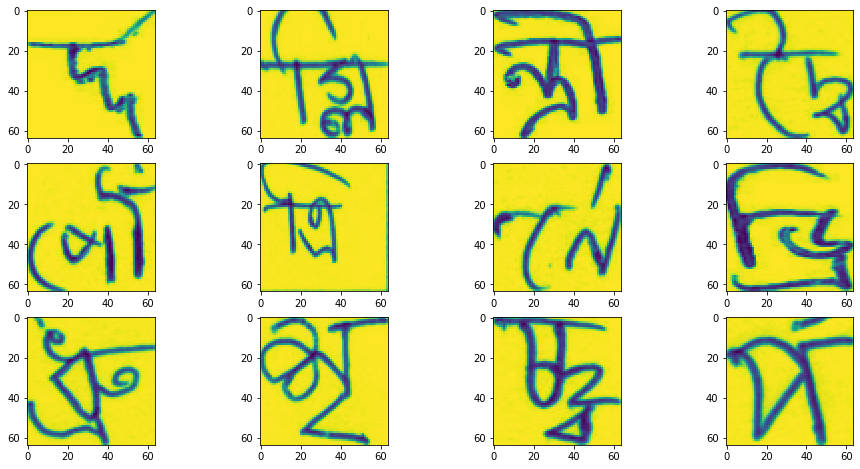


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/100
461/461 [==============================] - 58s 126ms/step - loss: 1.1101 - dense_3_loss: 0.6701 - dense_4_loss: 0.2465 - dense_5_loss: 0.1935 - dense_3_accuracy: 0.8539 - dense_4_accuracy: 0.9393 - dense_5_accuracy: 0.9534 - val_loss: 0.6977 - val_dense_3_loss: 0.4449 - val_dense_4_loss: 0.1223 - val_dense_5_loss: 0.1214 - val_dense_3_accuracy: 0.9022 - val_dense_4_accuracy: 0.9681 - val_dense_5_accuracy: 0.9719
Epoch 2/100
461/461 [==============================] - 58s 126ms/step - loss: 0.9275 - dense_3_loss: 0.5585 - dense_4_loss: 0.2089 - dense_5_loss: 0.1601 - dense_3_accuracy: 0.8620 - dense_4_accuracy: 0.9440 - dense_5_accuracy: 0.9572 - val_loss: 0.6335 - val_dense_3_loss: 0.4050 - val_dense_4_loss: 0.1097 - val_dense_5_loss: 0.1108 - val_dense_3_accuracy: 0.9059 - val_dense_4_accuracy: 0.9684 - val_dense_5_accuracy: 0.973

Epoch 20/100
461/461 [==============================] - 58s 126ms/step - loss: 0.5144 - dense_3_loss: 0.2937 - dense_4_loss: 0.1282 - dense_5_loss: 0.0925 - dense_3_accuracy: 0.9102 - dense_4_accuracy: 0.9607 - dense_5_accuracy: 0.9705 - val_loss: 0.4959 - val_dense_3_loss: 0.3111 - val_dense_4_loss: 0.0861 - val_dense_5_loss: 0.0918 - val_dense_3_accuracy: 0.9174 - val_dense_4_accuracy: 0.9761 - val_dense_5_accuracy: 0.9759
Epoch 21/100
461/461 [==============================] - 58s 126ms/step - loss: 0.5123 - dense_3_loss: 0.2919 - dense_4_loss: 0.1265 - dense_5_loss: 0.0939 - dense_3_accuracy: 0.9101 - dense_4_accuracy: 0.9618 - dense_5_accuracy: 0.9700 - val_loss: 0.5052 - val_dense_3_loss: 0.3137 - val_dense_4_loss: 0.0915 - val_dense_5_loss: 0.0927 - val_dense_3_accuracy: 0.9176 - val_dense_4_accuracy: 0.9749 - val_dense_5_accuracy: 0.9739
Epoch 22/100
461/461 [==============================] - 58s 126ms/step - loss: 0.5033 - dense_3_loss: 0.2846 - dense_4_loss: 0.1275 - dense_5_

461/461 [==============================] - 58s 126ms/step - loss: 0.2882 - dense_3_loss: 0.1500 - dense_4_loss: 0.0846 - dense_5_loss: 0.0536 - dense_3_accuracy: 0.9519 - dense_4_accuracy: 0.9736 - dense_5_accuracy: 0.9827 - val_loss: 0.5420 - val_dense_3_loss: 0.3369 - val_dense_4_loss: 0.0949 - val_dense_5_loss: 0.1014 - val_dense_3_accuracy: 0.9129 - val_dense_4_accuracy: 0.9754 - val_dense_5_accuracy: 0.9746
Epoch 59/100
461/461 [==============================] - 58s 126ms/step - loss: 0.2751 - dense_3_loss: 0.1413 - dense_4_loss: 0.0814 - dense_5_loss: 0.0524 - dense_3_accuracy: 0.9549 - dense_4_accuracy: 0.9740 - dense_5_accuracy: 0.9828 - val_loss: 0.5404 - val_dense_3_loss: 0.3395 - val_dense_4_loss: 0.0927 - val_dense_5_loss: 0.0998 - val_dense_3_accuracy: 0.9144 - val_dense_4_accuracy: 0.9761 - val_dense_5_accuracy: 0.9744
Epoch 60/100
461/461 [==============================] - 58s 126ms/step - loss: 0.2762 - dense_3_loss: 0.1475 - dense_4_loss: 0.0792 - dense_5_loss: 0.0496 

461/461 [==============================] - 58s 126ms/step - loss: 0.1931 - dense_3_loss: 0.0956 - dense_4_loss: 0.0610 - dense_5_loss: 0.0365 - dense_3_accuracy: 0.9695 - dense_4_accuracy: 0.9810 - dense_5_accuracy: 0.9880 - val_loss: 0.5932 - val_dense_3_loss: 0.3664 - val_dense_4_loss: 0.1046 - val_dense_5_loss: 0.1127 - val_dense_3_accuracy: 0.9139 - val_dense_4_accuracy: 0.9744 - val_dense_5_accuracy: 0.9729
Epoch 97/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1934 - dense_3_loss: 0.0951 - dense_4_loss: 0.0626 - dense_5_loss: 0.0357 - dense_3_accuracy: 0.9702 - dense_4_accuracy: 0.9800 - dense_5_accuracy: 0.9882 - val_loss: 0.6032 - val_dense_3_loss: 0.3675 - val_dense_4_loss: 0.1128 - val_dense_5_loss: 0.1143 - val_dense_3_accuracy: 0.9121 - val_dense_4_accuracy: 0.9706 - val_dense_5_accuracy: 0.9721
Epoch 98/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1886 - dense_3_loss: 0.0927 - dense_4_loss: 0.0592 - dense_5_loss: 0.0367 

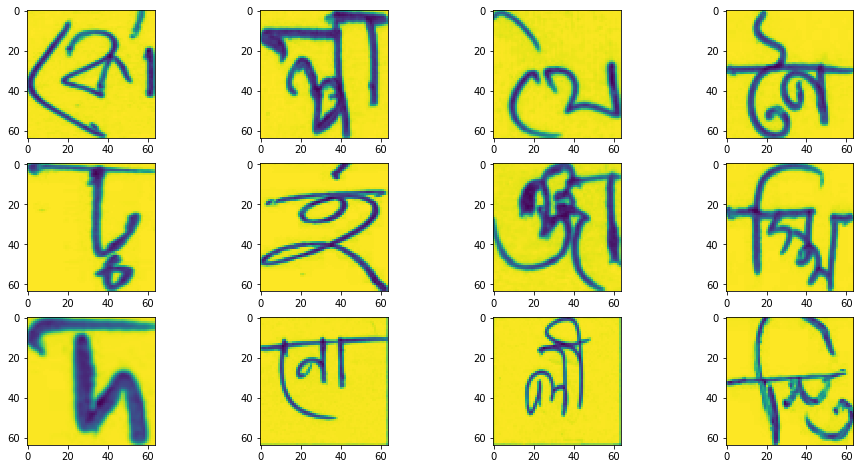


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/100
461/461 [==============================] - 58s 126ms/step - loss: 0.8145 - dense_3_loss: 0.4870 - dense_4_loss: 0.1821 - dense_5_loss: 0.1454 - dense_3_accuracy: 0.8761 - dense_4_accuracy: 0.9498 - dense_5_accuracy: 0.9589 - val_loss: 0.5338 - val_dense_3_loss: 0.3397 - val_dense_4_loss: 0.0890 - val_dense_5_loss: 0.1042 - val_dense_3_accuracy: 0.9176 - val_dense_4_accuracy: 0.9788 - val_dense_5_accuracy: 0.9711
Epoch 2/100
461/461 [==============================] - 58s 126ms/step - loss: 0.7066 - dense_3_loss: 0.4208 - dense_4_loss: 0.1606 - dense_5_loss: 0.1253 - dense_3_accuracy: 0.8833 - dense_4_accuracy: 0.9532 - dense_5_accuracy: 0.9615 - val_loss: 0.5042 - val_dense_3_loss: 0.3210 - val_dense_4_loss: 0.0850 - val_dense_5_loss: 0.0986 - val_dense_3_accuracy: 0.9166 - val_dense_4_accuracy: 0.9796 - val_dense_5_accuracy: 0.971

Epoch 20/100
461/461 [==============================] - 58s 126ms/step - loss: 0.4183 - dense_3_loss: 0.2369 - dense_4_loss: 0.1078 - dense_5_loss: 0.0736 - dense_3_accuracy: 0.9282 - dense_4_accuracy: 0.9667 - dense_5_accuracy: 0.9761 - val_loss: 0.4448 - val_dense_3_loss: 0.2810 - val_dense_4_loss: 0.0756 - val_dense_5_loss: 0.0872 - val_dense_3_accuracy: 0.9246 - val_dense_4_accuracy: 0.9816 - val_dense_5_accuracy: 0.9746
Epoch 21/100
461/461 [==============================] - 58s 126ms/step - loss: 0.4252 - dense_3_loss: 0.2404 - dense_4_loss: 0.1080 - dense_5_loss: 0.0768 - dense_3_accuracy: 0.9265 - dense_4_accuracy: 0.9664 - dense_5_accuracy: 0.9756 - val_loss: 0.4481 - val_dense_3_loss: 0.2801 - val_dense_4_loss: 0.0788 - val_dense_5_loss: 0.0884 - val_dense_3_accuracy: 0.9236 - val_dense_4_accuracy: 0.9811 - val_dense_5_accuracy: 0.9744
Epoch 22/100
461/461 [==============================] - 58s 126ms/step - loss: 0.4057 - dense_3_loss: 0.2299 - dense_4_loss: 0.1017 - dense_5_

461/461 [==============================] - 58s 126ms/step - loss: 0.2425 - dense_3_loss: 0.1215 - dense_4_loss: 0.0768 - dense_5_loss: 0.0443 - dense_3_accuracy: 0.9605 - dense_4_accuracy: 0.9763 - dense_5_accuracy: 0.9857 - val_loss: 0.4877 - val_dense_3_loss: 0.3031 - val_dense_4_loss: 0.0807 - val_dense_5_loss: 0.1021 - val_dense_3_accuracy: 0.9248 - val_dense_4_accuracy: 0.9791 - val_dense_5_accuracy: 0.9716
Epoch 59/100
461/461 [==============================] - 58s 127ms/step - loss: 0.2374 - dense_3_loss: 0.1230 - dense_4_loss: 0.0699 - dense_5_loss: 0.0445 - dense_3_accuracy: 0.9605 - dense_4_accuracy: 0.9777 - dense_5_accuracy: 0.9851 - val_loss: 0.4848 - val_dense_3_loss: 0.3013 - val_dense_4_loss: 0.0818 - val_dense_5_loss: 0.0993 - val_dense_3_accuracy: 0.9256 - val_dense_4_accuracy: 0.9786 - val_dense_5_accuracy: 0.9746
Epoch 60/100
461/461 [==============================] - 58s 126ms/step - loss: 0.2345 - dense_3_loss: 0.1177 - dense_4_loss: 0.0721 - dense_5_loss: 0.0448 

461/461 [==============================] - 58s 126ms/step - loss: 0.1614 - dense_3_loss: 0.0757 - dense_4_loss: 0.0559 - dense_5_loss: 0.0299 - dense_3_accuracy: 0.9761 - dense_4_accuracy: 0.9824 - dense_5_accuracy: 0.9903 - val_loss: 0.5157 - val_dense_3_loss: 0.3185 - val_dense_4_loss: 0.0861 - val_dense_5_loss: 0.1071 - val_dense_3_accuracy: 0.9273 - val_dense_4_accuracy: 0.9798 - val_dense_5_accuracy: 0.9749
Epoch 97/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1647 - dense_3_loss: 0.0787 - dense_4_loss: 0.0534 - dense_5_loss: 0.0326 - dense_3_accuracy: 0.9755 - dense_4_accuracy: 0.9839 - dense_5_accuracy: 0.9901 - val_loss: 0.5248 - val_dense_3_loss: 0.3190 - val_dense_4_loss: 0.0907 - val_dense_5_loss: 0.1105 - val_dense_3_accuracy: 0.9258 - val_dense_4_accuracy: 0.9773 - val_dense_5_accuracy: 0.9739
Epoch 98/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1639 - dense_3_loss: 0.0806 - dense_4_loss: 0.0521 - dense_5_loss: 0.0312 

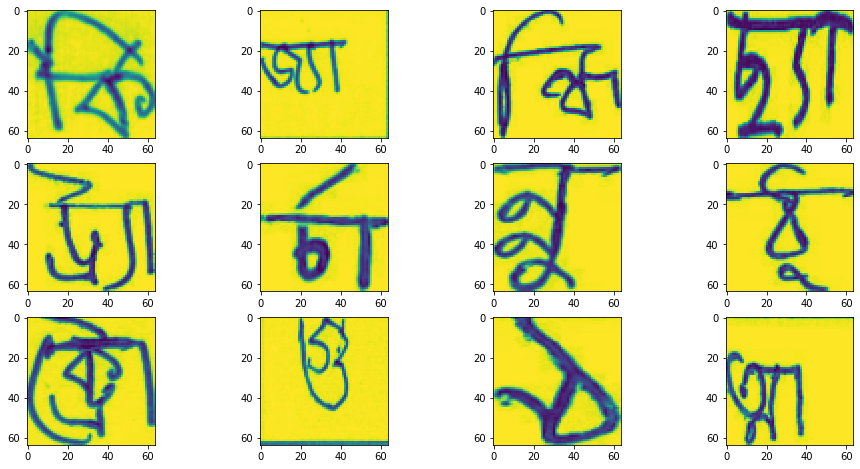


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/100
461/461 [==============================] - 58s 126ms/step - loss: 0.7445 - dense_3_loss: 0.4411 - dense_4_loss: 0.1702 - dense_5_loss: 0.1332 - dense_3_accuracy: 0.8893 - dense_4_accuracy: 0.9527 - dense_5_accuracy: 0.9633 - val_loss: 0.4463 - val_dense_3_loss: 0.2782 - val_dense_4_loss: 0.0882 - val_dense_5_loss: 0.0711 - val_dense_3_accuracy: 0.9231 - val_dense_4_accuracy: 0.9771 - val_dense_5_accuracy: 0.9764
Epoch 2/100
461/461 [==============================] - 58s 126ms/step - loss: 0.6285 - dense_3_loss: 0.3704 - dense_4_loss: 0.1445 - dense_5_loss: 0.1136 - dense_3_accuracy: 0.8972 - dense_4_accuracy: 0.9570 - dense_5_accuracy: 0.9656 - val_loss: 0.4140 - val_dense_3_loss: 0.2575 - val_dense_4_loss: 0.0822 - val_dense_5_loss: 0.0662 - val_dense_3_accuracy: 0.9278 - val_dense_4_accuracy: 0.9783 - val_dense_5_accuracy: 0.978

Epoch 20/100
461/461 [==============================] - 58s 126ms/step - loss: 0.3756 - dense_3_loss: 0.2045 - dense_4_loss: 0.1004 - dense_5_loss: 0.0707 - dense_3_accuracy: 0.9358 - dense_4_accuracy: 0.9688 - dense_5_accuracy: 0.9773 - val_loss: 0.3814 - val_dense_3_loss: 0.2365 - val_dense_4_loss: 0.0767 - val_dense_5_loss: 0.0607 - val_dense_3_accuracy: 0.9325 - val_dense_4_accuracy: 0.9798 - val_dense_5_accuracy: 0.9838
Epoch 21/100
461/461 [==============================] - 58s 126ms/step - loss: 0.3660 - dense_3_loss: 0.2047 - dense_4_loss: 0.0981 - dense_5_loss: 0.0632 - dense_3_accuracy: 0.9360 - dense_4_accuracy: 0.9696 - dense_5_accuracy: 0.9794 - val_loss: 0.3822 - val_dense_3_loss: 0.2361 - val_dense_4_loss: 0.0786 - val_dense_5_loss: 0.0600 - val_dense_3_accuracy: 0.9348 - val_dense_4_accuracy: 0.9801 - val_dense_5_accuracy: 0.9831
Epoch 22/100
461/461 [==============================] - 58s 126ms/step - loss: 0.3560 - dense_3_loss: 0.1947 - dense_4_loss: 0.0941 - dense_5_

461/461 [==============================] - 58s 126ms/step - loss: 0.2097 - dense_3_loss: 0.1015 - dense_4_loss: 0.0669 - dense_5_loss: 0.0414 - dense_3_accuracy: 0.9678 - dense_4_accuracy: 0.9793 - dense_5_accuracy: 0.9872 - val_loss: 0.4406 - val_dense_3_loss: 0.2754 - val_dense_4_loss: 0.0882 - val_dense_5_loss: 0.0683 - val_dense_3_accuracy: 0.9313 - val_dense_4_accuracy: 0.9793 - val_dense_5_accuracy: 0.9841
Epoch 59/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1998 - dense_3_loss: 0.0952 - dense_4_loss: 0.0636 - dense_5_loss: 0.0410 - dense_3_accuracy: 0.9699 - dense_4_accuracy: 0.9802 - dense_5_accuracy: 0.9874 - val_loss: 0.4480 - val_dense_3_loss: 0.2792 - val_dense_4_loss: 0.0892 - val_dense_5_loss: 0.0705 - val_dense_3_accuracy: 0.9308 - val_dense_4_accuracy: 0.9788 - val_dense_5_accuracy: 0.9828
Epoch 60/100
461/461 [==============================] - 58s 126ms/step - loss: 0.2072 - dense_3_loss: 0.1013 - dense_4_loss: 0.0665 - dense_5_loss: 0.0394 

461/461 [==============================] - 58s 126ms/step - loss: 0.1438 - dense_3_loss: 0.0670 - dense_4_loss: 0.0473 - dense_5_loss: 0.0294 - dense_3_accuracy: 0.9794 - dense_4_accuracy: 0.9852 - dense_5_accuracy: 0.9907 - val_loss: 0.4884 - val_dense_3_loss: 0.3110 - val_dense_4_loss: 0.0919 - val_dense_5_loss: 0.0759 - val_dense_3_accuracy: 0.9286 - val_dense_4_accuracy: 0.9788 - val_dense_5_accuracy: 0.9826
Epoch 97/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1475 - dense_3_loss: 0.0682 - dense_4_loss: 0.0505 - dense_5_loss: 0.0288 - dense_3_accuracy: 0.9786 - dense_4_accuracy: 0.9845 - dense_5_accuracy: 0.9910 - val_loss: 0.4949 - val_dense_3_loss: 0.3145 - val_dense_4_loss: 0.0952 - val_dense_5_loss: 0.0754 - val_dense_3_accuracy: 0.9273 - val_dense_4_accuracy: 0.9771 - val_dense_5_accuracy: 0.9833
Epoch 98/100
461/461 [==============================] - 58s 126ms/step - loss: 0.1451 - dense_3_loss: 0.0654 - dense_4_loss: 0.0503 - dense_5_loss: 0.0295 

In [40]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image # 0.8~1.2?
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant,earlyStop])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [41]:
# https://www.kaggle.com/amanooo/bengali-ai-multi-output-densenet121-keras

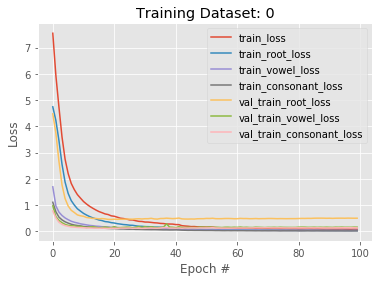

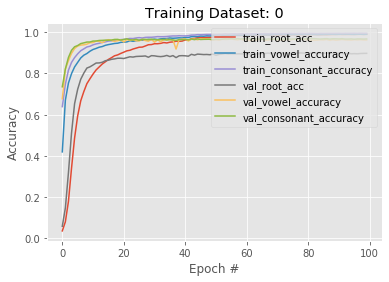

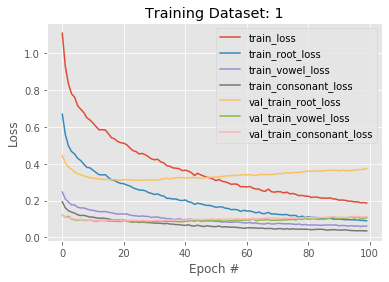

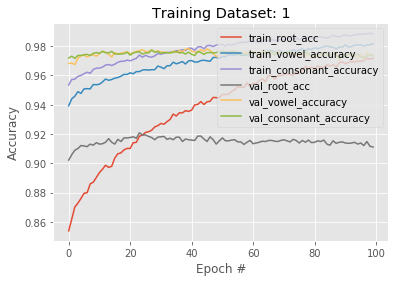

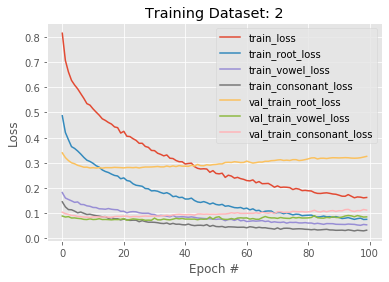

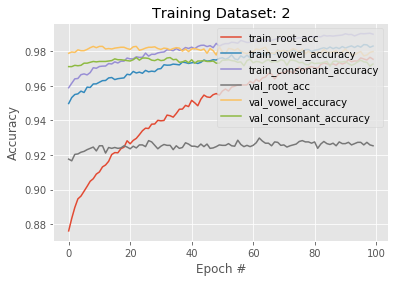

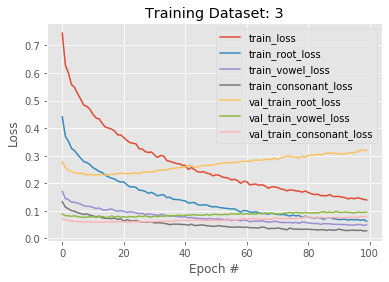

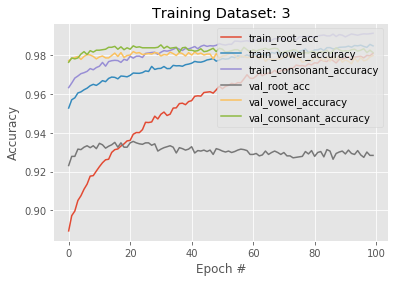

In [42]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [43]:
del histories
gc.collect()

29743

In [44]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [45]:
# # Save the model
# loaded_model.save('Eff_model2.h5')


In [46]:
# Save the model
model.save('Eff_model3_64.h5')

# from keras.models import load_model
# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('Eff_model2.h5')

In [ ]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("Eff_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("Eff_model.h5")
# print("Saved model to disk")

In [5]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('Eff_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("Eff_model.h5")
# print("Loaded model from disk")

Loaded model from disk


In [ ]:
# components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
# target=[] # model predictions placeholder
# row_id=[] # row_id place holder
# for i in range(4):
#     df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
#     df_test_img.set_index('image_id', inplace=True)

#     X_test = resize(df_test_img, need_progress_bar=False)/255
#     X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#     preds = model.predict(X_test)

#     for i, p in enumerate(preds_dict):
#         preds_dict[p] = np.argmax(preds[i], axis=1)

#     for k,id in enumerate(df_test_img.index.values):  
#         for i,comp in enumerate(components):
#             id_sample=id+'_'+comp
#             row_id.append(id_sample)
#             target.append(preds_dict[comp][k])
#     del df_test_img
#     del X_test
#     gc.collect()

# df_sample = pd.DataFrame(
#     {
#         'row_id': row_id,
#         'target':target
#     },
#     columns = ['row_id','target'] 
# )
# df_sample.to_csv('submission.csv',index=False)
# df_sample.head()